In [60]:
%%bash
pwd

/home/kun/work/learning/python-machine-learning-book-2nd-edition/code/ch02


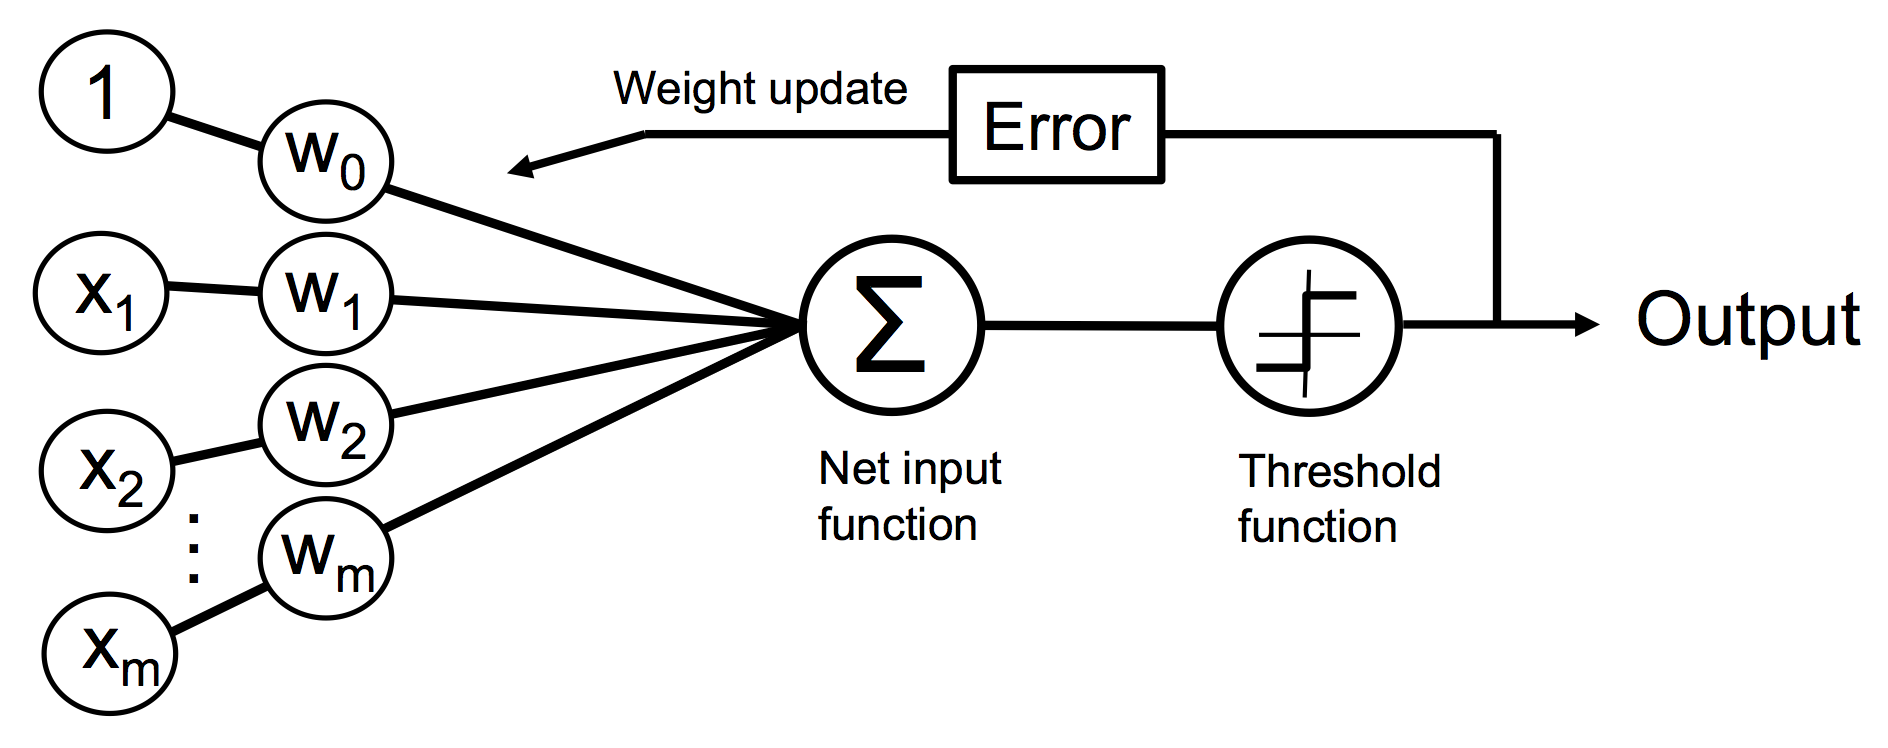

In [61]:
from IPython.display import Image
Image(filename = './images/02_04.png', width = 600)

In [62]:
import numpy as np

class Perceptron(object):
    def __init__(self, eta=0.01, n_iter=50, random_state=27):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state) # an instance of the class
        self.w_ = rgen.normal(loc=0.0, scale = 0.01, size = 1 + X.shape[1])
        self.errors_ = []
        
        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
        
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df.tail()

0    1    2    3               4
145  6.7  3.0  5.2  2.3  Iris-virginica
146  6.3  2.5  5.0  1.9  Iris-virginica
147  6.5  3.0  5.2  2.0  Iris-virginica
148  6.2  3.4  5.4  2.3  Iris-virginica
149  5.9  3.0  5.1  1.8  Iris-virginica

In [64]:
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)
X = df.iloc[0:100, [0, 2]].values

In [65]:
ppn = Perceptron(eta=0.1, n_iter=10)

ppn.fit(X, y)

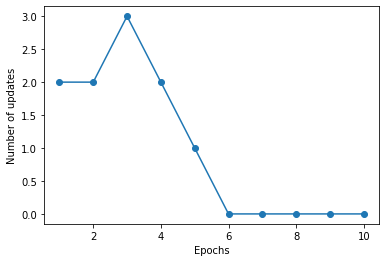

In [66]:
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')

# plt.savefig('images/02_07.png', dpi=300)
plt.show()


## Adaptive linear neurons and the convergence of learning

### Minimizing cost function with gradient descent

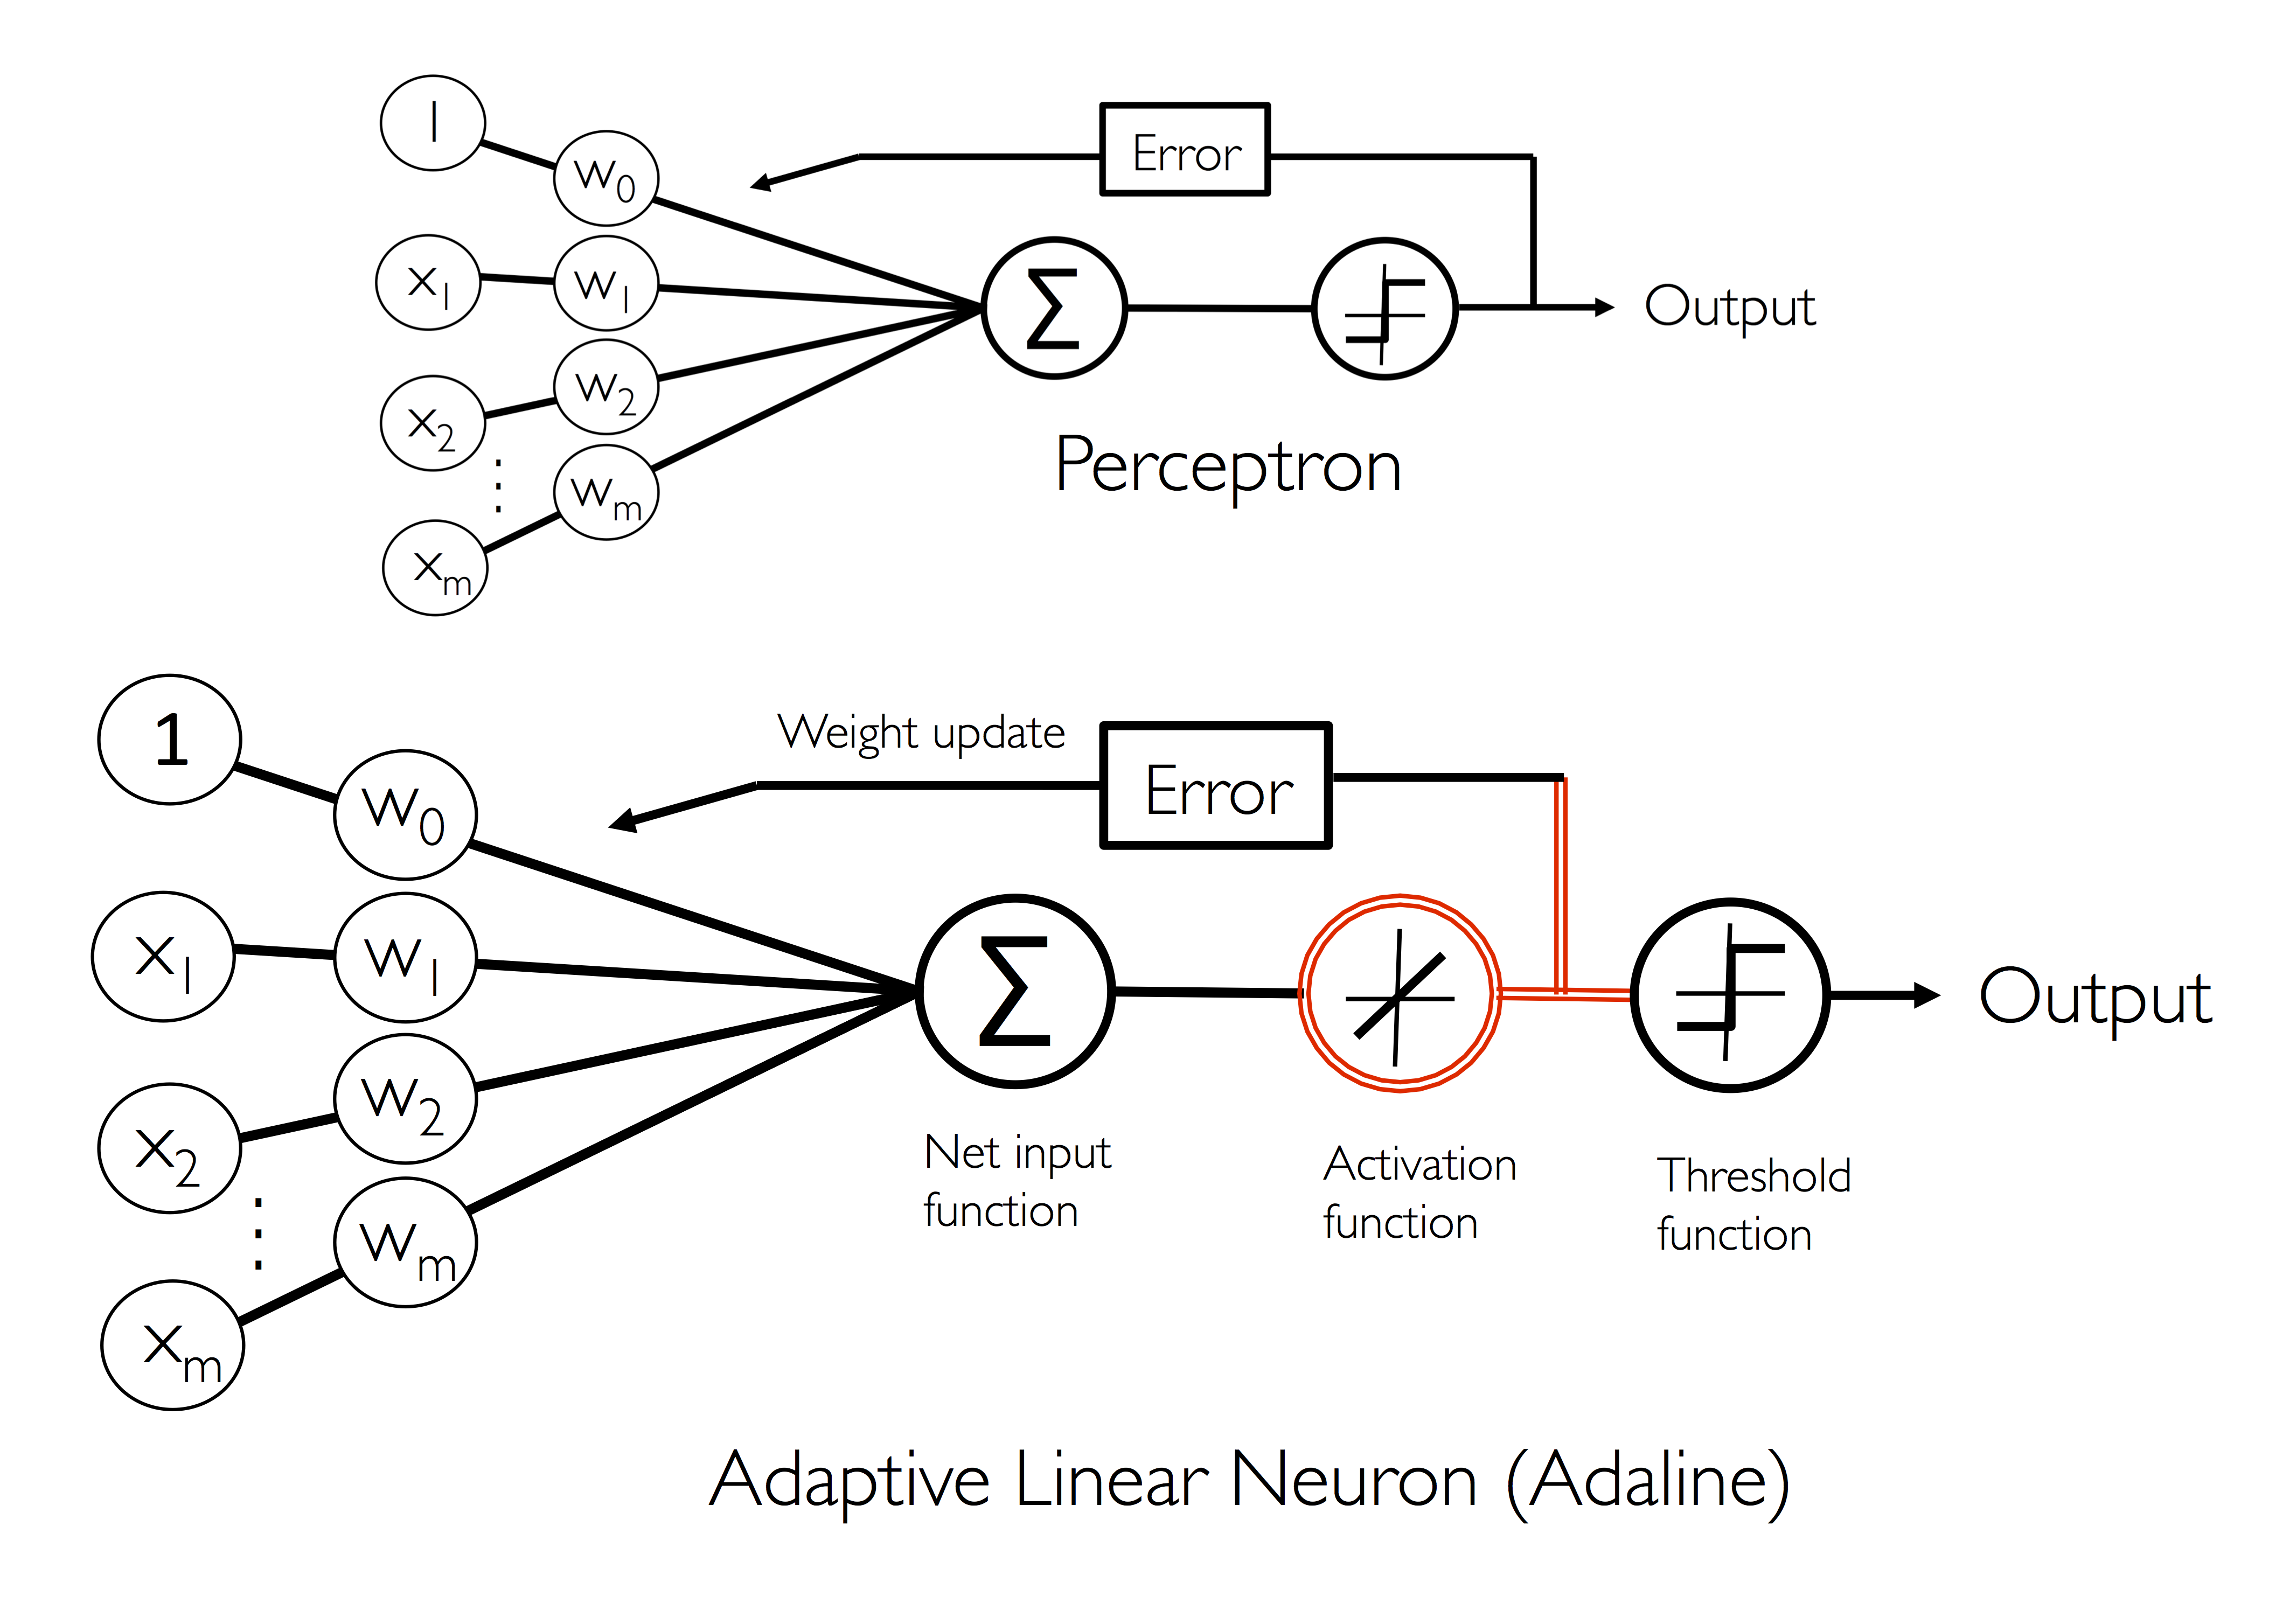

In [67]:
Image(filename='./images/02_09.png', width=600)

In [68]:
class AdalineGD(object):
    def __init__(self, eta=0.01, n_iter=50, random_state=7):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output) # this is a vector. Each element is one data point. y(i) - output(i)
            ## w_j is the sum over i for X_j(i) * errors(i), where i stands for the ith sample
            ## the output shape = [2, 1]: (2, 100) * (100, 1)
            ## so it needs to leverage all samples
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
            
    def net_input(self, X):
        ## each element of the output is a dot product of X(i) and w
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

In [69]:
#import numpy as np
#output = np.dot(X, [0.2, 0.8])
#output

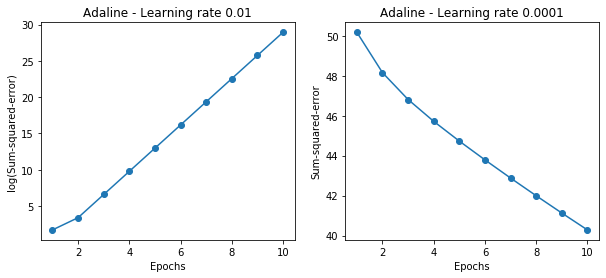

In [95]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate 0.0001')

# plt.savefig('images/02_11.png', dpi=300)
plt.show()

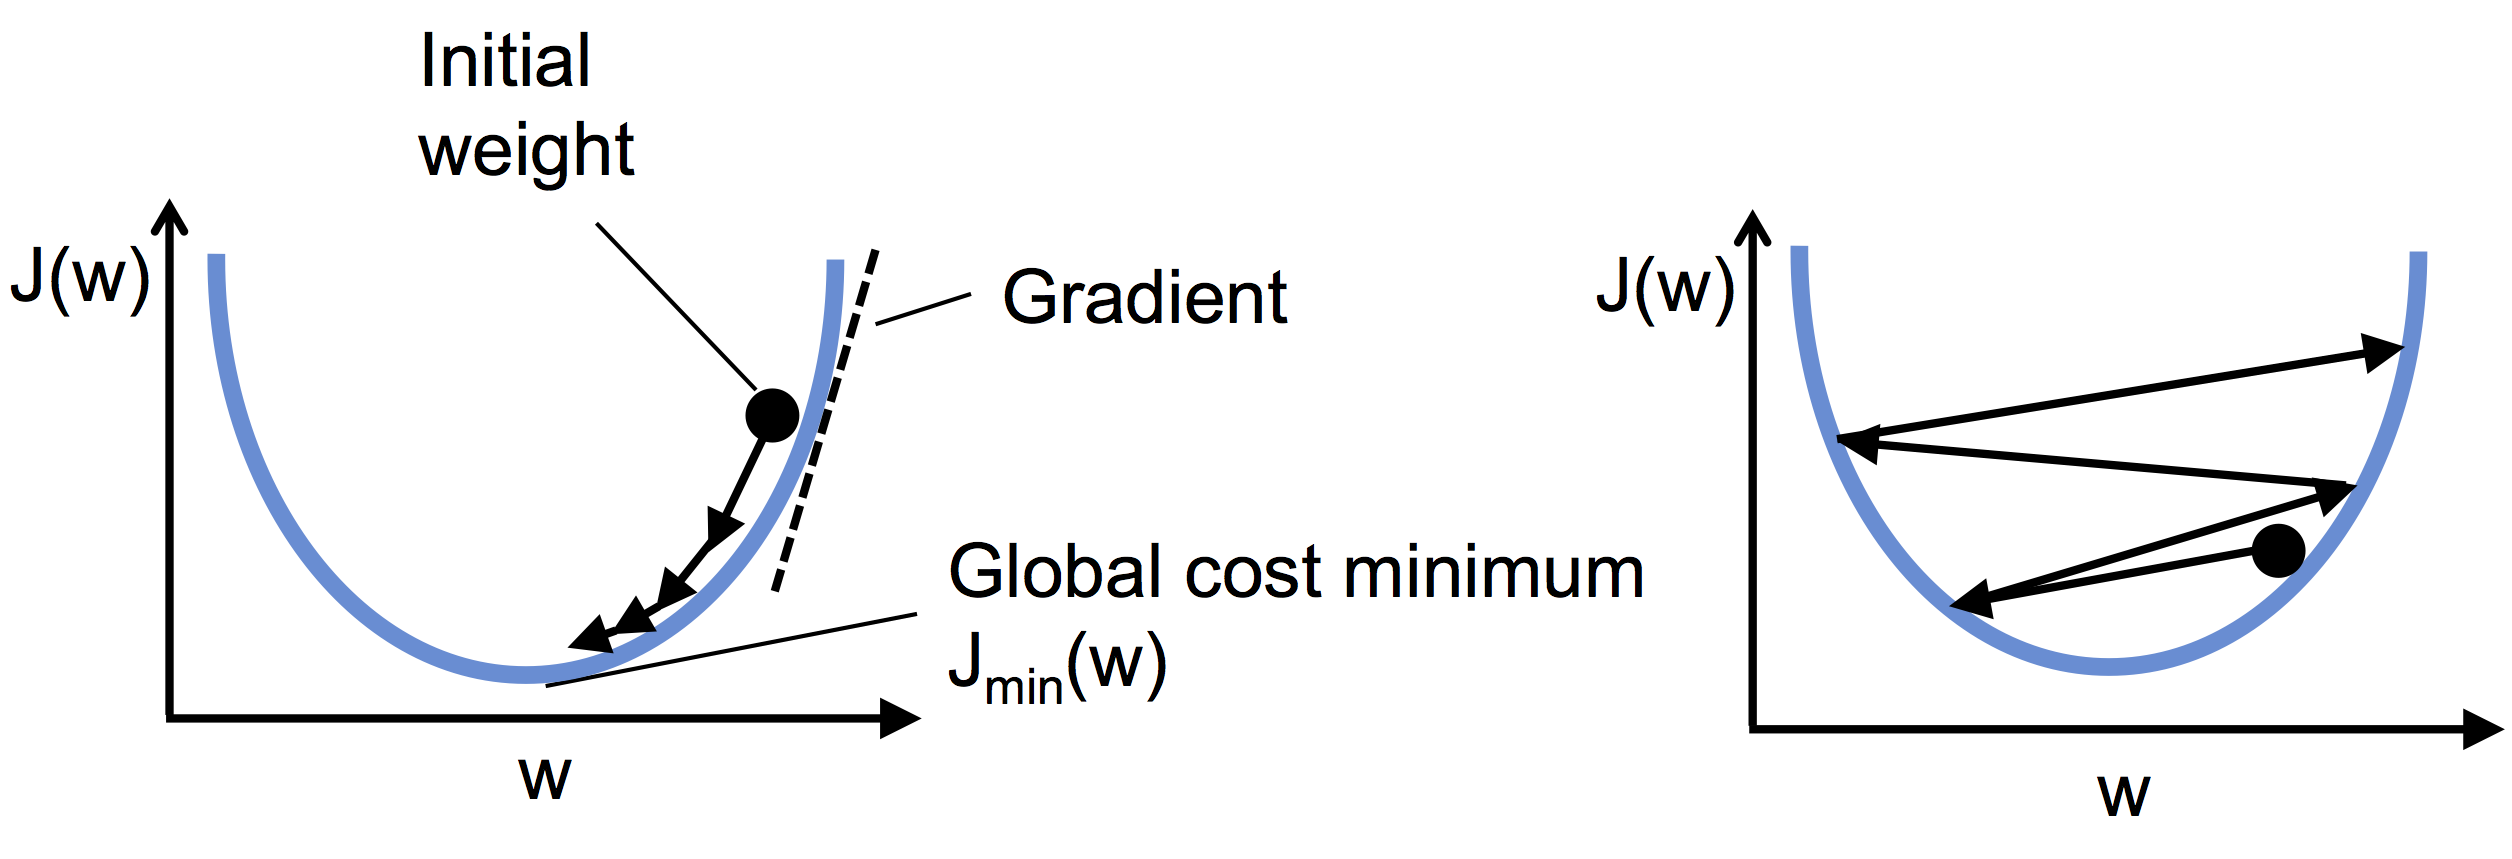

In [96]:
Image(filename='./images/02_12.png', width=700) # overshooting

In [77]:
# standardize features
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

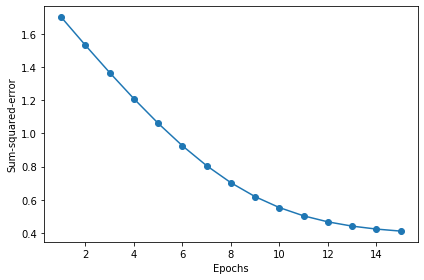

In [91]:
ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)

plt.plot(range(1, len(ada.cost_) + 1), np.log10(ada.cost_), marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')

plt.tight_layout()
# plt.savefig('images/02_14_2.png', dpi=300)
plt.show()

## Large scale machine learning and stochastic gradient descent

In [ ]:
class AdalineSGD(object):
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        
    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        